# Кластеризация
__Суммарное количество баллов: 10__

В этом домашнем задании предлагается реализовать три различных метода кластеризации, понять, в каких случаях стоит применять те или иные методы.

In [5]:
from sklearn.neighbors import KDTree
from sklearn.datasets import make_blobs, make_moons, make_swiss_roll
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import cv2
from collections import deque

In [77]:
def visualize_clasters(X, labels):
    unique_labels = np.unique(labels)
    unique_colors = np.random.random((len(unique_labels), 3))
    colors = [unique_colors[l] for l in labels]
    plt.figure(figsize=(9, 9))
    plt.scatter(X[:, 0], X[:, 1], c=colors)
    plt.show()

def clusters_statistics(flatten_image, cluster_colors, cluster_labels):
    fig, axes = plt.subplots(3, 2, figsize=(12, 16))
    for remove_color in range(3):
        axes_pair = axes[remove_color]
        first_color = 0 if remove_color != 0 else 2
        second_color = 1 if remove_color != 1 else 2
        axes_pair[0].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=flatten_image, marker='.')
        axes_pair[1].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=[cluster_colors[c] for c in cluster_labels], marker='.')
        for a in axes_pair:
            a.set_xlim(0, 1)
            a.set_ylim(0, 1)
    plt.show()

Генерируем два синтетических набора данных для кластеризации. Далее будем тестировать наши алгоритмы на них.

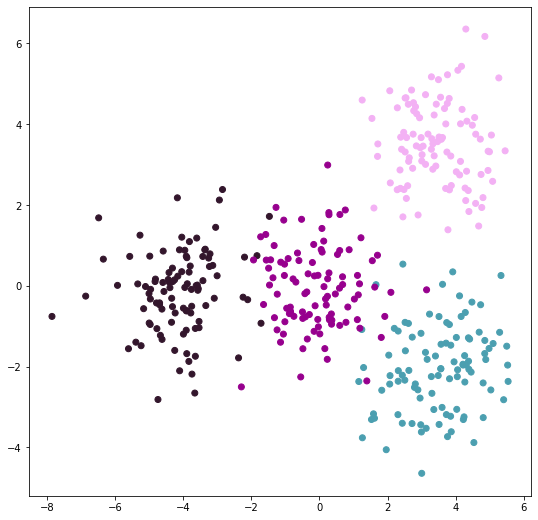

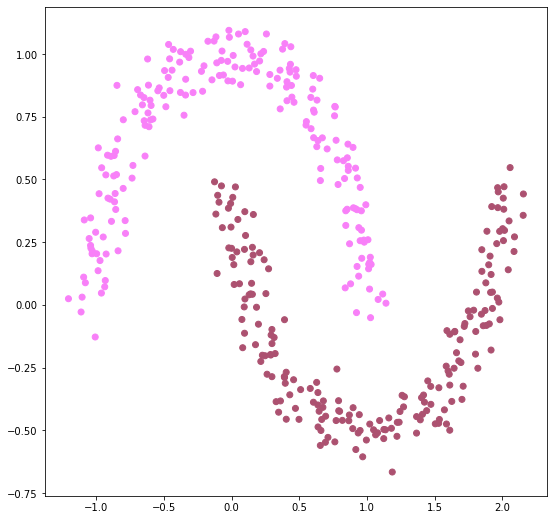

In [9]:
X_1, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])
visualize_clasters(X_1, true_labels)
X_2, true_labels = make_moons(400, noise=0.075)
visualize_clasters(X_2, true_labels)
# print(X_1)

### Задание 1 (2 балла)
Первый метод, который предлагается реализовать - метод K средних.

#### Описание методов
`fit(X, y=None)` ищет и запоминает в `self.centroids` центроиды кластеров для набора данных.
`predict(X)` для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент.

#### Инициализация кластеров
Есть несколько вариантов инициализации кластеров. Нужно реализовать их все:
1. `random` - центроиды кластеров являются случайными точками
2. `sample` - центроиды кластеров выбираются случайно из набора данных
3. `k-means++` - центроиды кластеров инициализируются при помощи метода K-means++


In [144]:
import math
import random
class KMeans:
    n_clusters = None
    centroids = None
    method = None
    max_iter = None
    max_dist = None
    def __init__(self, n_clusters, init="random", max_iter=300):
        self.n_clusters = n_clusters
        self.method = init
        self.max_iter = max_iter
        self.centroids = []
        
    def fit(self, X, y=None): # 2 dimensions
        n=len(X)
        down = np.amin(X)
        up = np.amax(X)
        self.max_dist = up - down
        if self.method == "random":
            for _ in range(self.n_clusters):
                self.centroids.append([random.uniform(down,up), random.uniform(down,up)])
        elif self.method == "sample":
            self.centroids = X[np.random.choice(X.shape[0], self.n_clusters, replace=False), :]
        elif self.method == "k-means++":
            self.centroids.append(X[np.random.choice(X.shape[0], 1, replace=False), :].flatten())
            for _ in range(self.n_clusters-1):
                dist = [self.max_dist**2 for _ in range(n)]
                sum = 0
                for i in range(n):
                    for center in self.centroids: # Считаем расстояния
                        tmp = math.sqrt((center[0] - X[i][0])**2 + (center[1] - X[i][1])**2)
                        if tmp < dist[i]:
                            dist[i] = tmp
                    dist[i] *= dist[i]
                    sum+=dist[i]
                for i in range(n):
                    dist[i] /= sum # Считаем вероятности
                new_center = np.random.choice(n, 1, p = dist)
                self.centroids.append(X[new_center].flatten())
            
        labels = [0 for _ in range(n)]
        for _ in range(self.max_iter):
            for i in range(n):
                dist = self.max_dist**2
                for ix, center in enumerate(self.centroids):
                    tmp = math.sqrt((center[0] - X[i][0])**2 + (center[1] - X[i][1])**2)
                    if tmp < dist:
                        dist = tmp
                        labels[i] = ix
            for i in range(len(self.centroids)):
                sum_x = 0
                sum_y = 0
                cnt = 0
                for j in range(len(labels)):
                    if labels[j] == i:
                        cnt+=1
                        sum_x += X[j][0]
                        sum_y+= X[j][1]
                if cnt == 0:
                    continue
                self.centroids[i][0] = sum_x/cnt
                self.centroids[i][1] = sum_y/cnt
#         unique_labels = np.unique(labels)
#         d = {}
#         print(n, len(labels))
#         for i in range(len(unique_labels)):
#             d[unique_labels[i]] = i
#         for i in range(len(labels)):
#             labels[i] = d[labels[i]]
            
            
    
    def predict(self, X):
        n = len(X)
        labels = [0 for _ in range(n)]
        for i,point in enumerate(X):
            dist = self.max_dist**2
            for ix, center in enumerate(self.centroids):
                tmp = math.sqrt((center[0] - point[0])**2 + (center[1] - point[1])**2)
                if tmp < dist:
                    dist = tmp
                    labels[i] = ix
        unique_labels = np.unique(labels) # Сортируем лейблы подряд
        if self.method == "random":
            d = {}
            for i in range(len(unique_labels)):
                d[unique_labels[i]] = i
            for i in range(len(labels)) :
                labels[i] = d[labels[i]]
#         print(labels)
        return labels
        

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

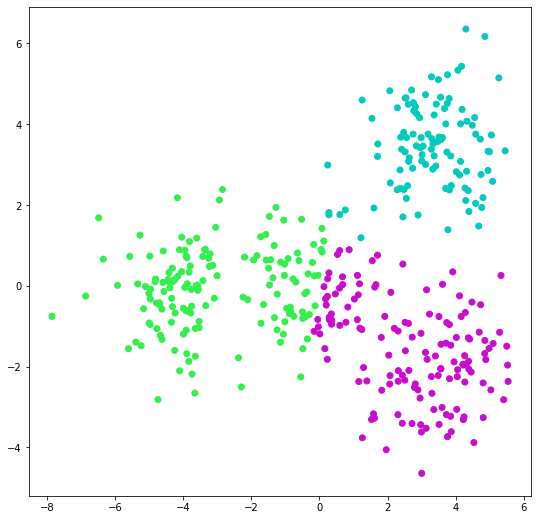

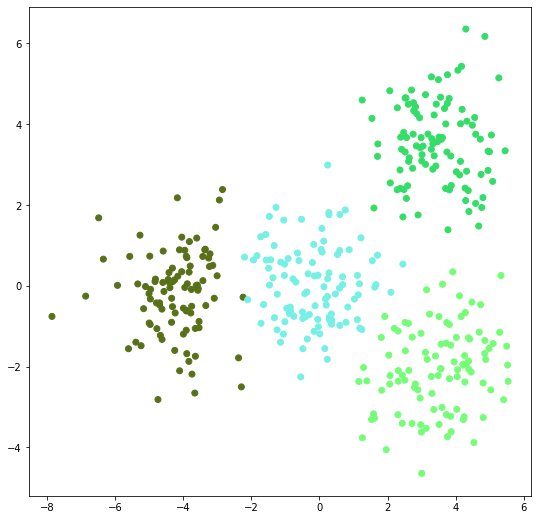

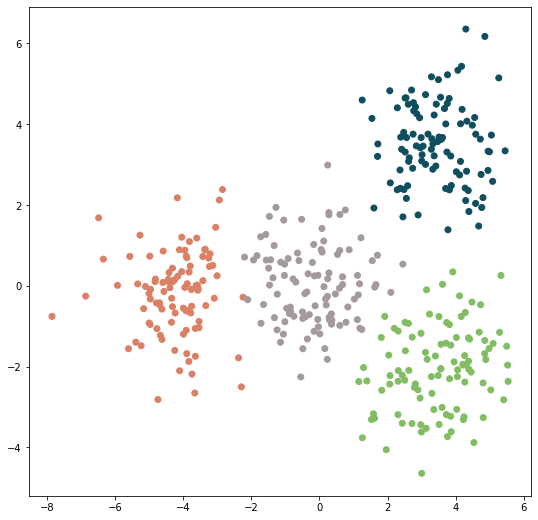

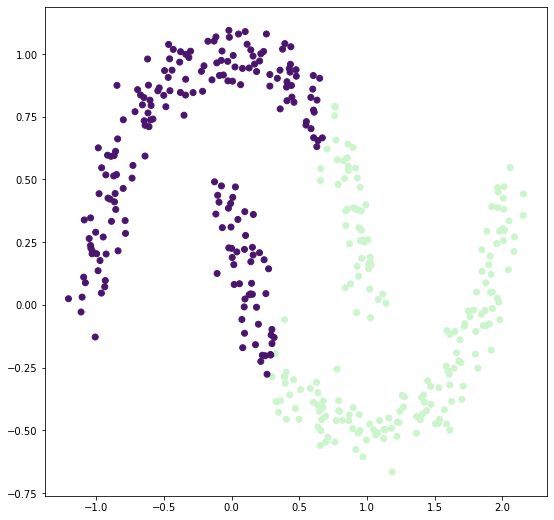

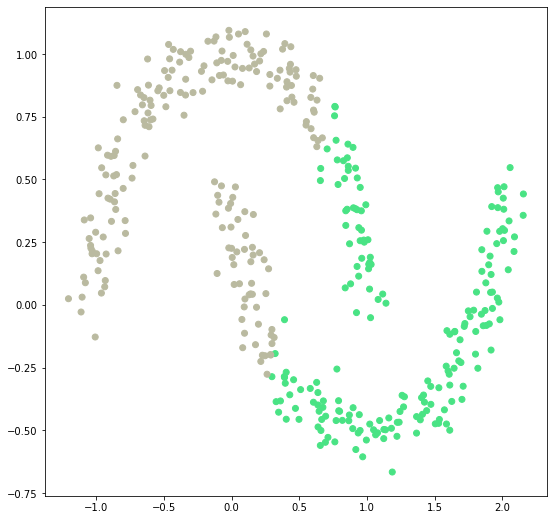

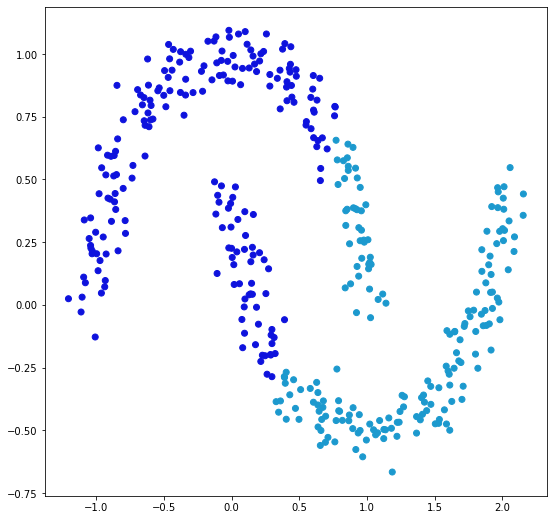

In [147]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X_1)
labels = kmeans.predict(X_1)
visualize_clasters(X_1, labels)

kmeans = KMeans(n_clusters=4,init = "sample")
kmeans.fit(X_1)
labels = kmeans.predict(X_1)
visualize_clasters(X_1, labels)

kmeans = KMeans(n_clusters=4,init = "k-means++")
kmeans.fit(X_1)
labels = kmeans.predict(X_1)
visualize_clasters(X_1, labels)

kmeans = KMeans(n_clusters=2)
kmeans.fit(X_2)
labels = kmeans.predict(X_2)
visualize_clasters(X_2, labels)

kmeans = KMeans(n_clusters=2, init = "sample")
kmeans.fit(X_2)
labels = kmeans.predict(X_2)
visualize_clasters(X_2, labels)

kmeans = KMeans(n_clusters=2, init = "k-means++")
kmeans.fit(X_2)
labels = kmeans.predict(X_2)
visualize_clasters(X_2, labels)

### Задание 2 (4 балла)
В отличии от K-means, DBScan не позволяет задать количество кластеров, на которое будут разбиты данные. Руководствуясь геометрической интерпретацией, он позволяет выделять кластеры более сложной формы.

#### Описание методов
`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

#### Возможные метрики
* `euclidean`
* `manhattan`
* `chebyshev`

__Для быстрого поиска соседей используйте `sklearn.neighbors.KDTree`__

In [284]:
from sklearn.neighbors import KDTree
import math
from collections import deque
class DBScan:
    min_nghbs = None
    eps = None
    leaf_size = None
    metric = None
    tree = None
    leaf_size = None
    def __init__(self, eps=0.5, min_samples=5, leaf_size=40, metric="euclidean"):
        self.min_nghbs = min_samples
        self.eps = eps
        self.leaf_size = leaf_size
        self.metric = metric
        self.leaf_size = leaf_size 
#     def dist(self, x,y):
#         if self.metric == "euclidian":
#             return math.sqrt((x[0]-y[0])**2+(x[1]-y[1])**2)
#         elif self.metric == "manhattan":
#             return 
#         elif self.metric == "chebyshev":
#             return max(abs(x[0]-y[0]), abs(x[1]-y[1]))
        
    def fit_predict(self, X, y=None):
        connections = {}
        self.tree = KDTree(X, metric = self.metric, leaf_size = self.leaf_size)
        active = [False for _ in range(len(X))] # Основная ли вершина
        cluster = [-1 for _ in range(len(X))] # изначально все вне кластера
        for ix,point in enumerate(X):
            ind = self.tree.query_radius([point], r=self.eps)
            ind = ind[0]
            if len(ind) < self.min_nghbs:
                continue
            else:
                active[ix] = True # делаем основной
                connections[ix] = ind
        num_claster = 0
        for i in range(len(X)):
            if active[i]:
                q = deque()
                q.append(i)
                while q: # Ищем все в кластере
                    el = q.popleft()
#                     print(el, type(el))
                    cluster[el] = num_claster
                    if active[el]: # Добавляем только из основных
#                         print(connections[el])
                        for el2 in connections[el]:
                            q.append(el2)
                    active[el] = False
                num_claster+=1
        return cluster
                    
                
                    
                    
        

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

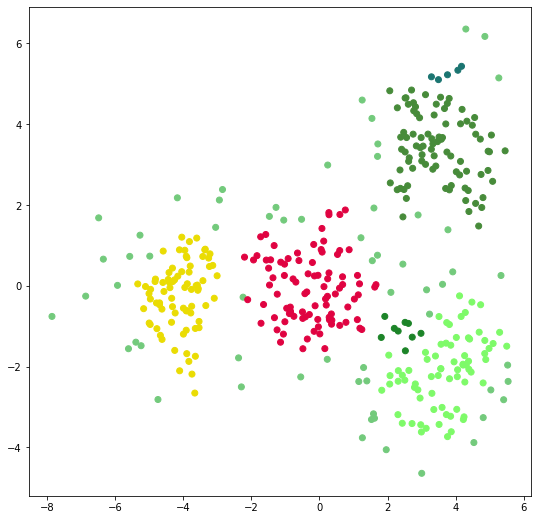

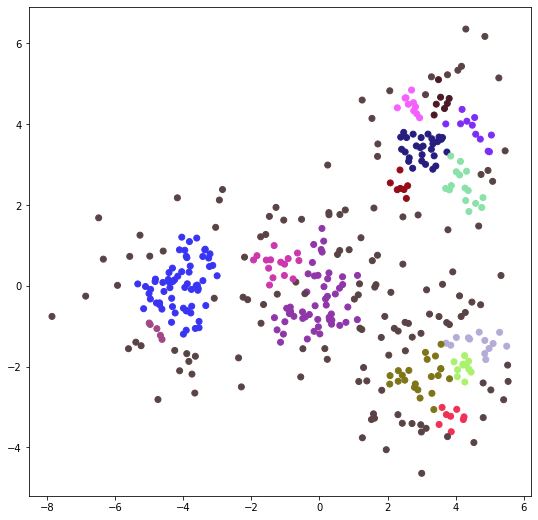

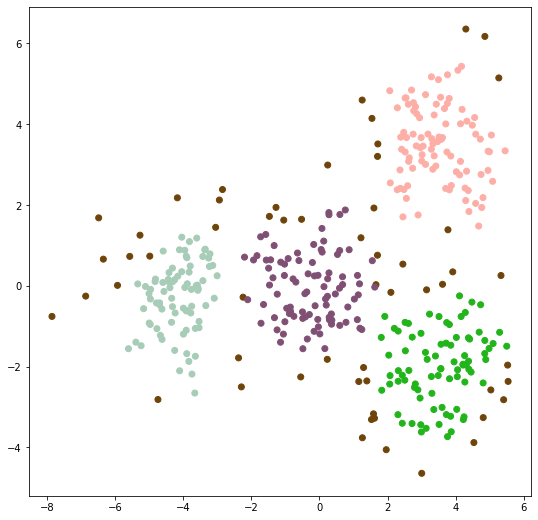

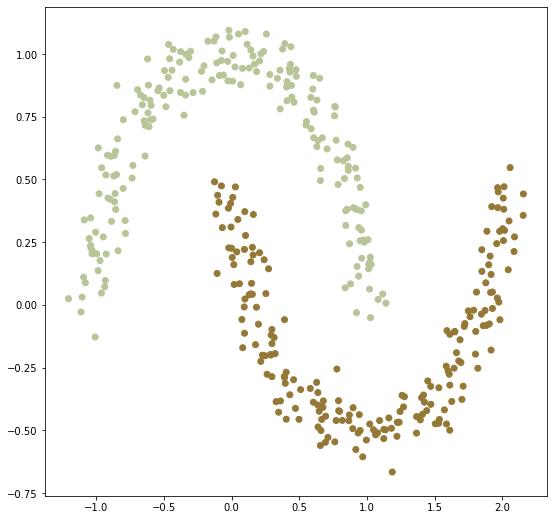

In [296]:
dbscan = DBScan()
labels = dbscan.fit_predict(X_1)
visualize_clasters(X_1, labels)

dbscan = DBScan(metric = "manhattan")
labels = dbscan.fit_predict(X_1)
visualize_clasters(X_1, labels)

dbscan = DBScan(metric = "chebyshev",eps = 0.48)
labels = dbscan.fit_predict(X_1)
visualize_clasters(X_1, labels)


dbscan = DBScan(eps = 0.2)
labels = dbscan.fit_predict(X_2)
visualize_clasters(X_2, labels)

### Задание 3 (4 балла)
Идея AgglomerativeClustering заключается в том, чтобы итеративно объединять кластеры с наименьшим расстоянием между ними. Данный метод обладает высокой вычислительной сложностью, поэтому применим только для относительно небольших наборов данных.

#### Описание методов
`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

#### Linkage-функции
__Linkage__ - это способ, которым будет рассчитываться расстояние между кластерами. Предлагается реализовать три варианта такой функции:
1. `average` - расстояние рассчитывается как среднее расстояние между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `single` - расстояние рассчитывается как минимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `complete` - расстояние рассчитывается как максимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.

In [263]:
import math
class AgglomertiveClustering:
    strategy = None
    n_clusters = None
    def __init__(self, n_clusters=16, linkage="average"):
        self.n_clusters = n_clusters
        self.strategy = linkage
    
    def find_distance(self, X, clusters, a, b):
        distances = [] # Собираем сюда все расстояния между точками
        if len(clusters[a]) == 0 or len(clusters[b])==0:
            raise ValueError('Empty clusters!')
        for i in clusters[a]:
            for j in clusters[b]:
                distances.append(math.sqrt((X[i][0] - X[j][0])**2 + (X[i][1] - X[j][1])**2 ))
        if self.strategy == "single":
            return min(distances)
        if self.strategy == "complete":
            return max(distances)
        if self.strategy == "average":
            return sum(distances)/len(distances)
                
    def fit_predict(self, X, y=None):
        n = len(X)
        down = np.amin(X)
        up = np.amax(X)
        max_dist = up - down
        clusters = [[i] for i in range(n)]
        active_clusters = [i for i in range(n)]
        distances = [[max_dist**2 for _ in range(n)] for _ in range(n)]
        for i in active_clusters:
            for j in active_clusters:
                if i!=j and distances[i][j] == max_dist**2: # Первый рассчет по всем
                    tmp = self.find_distance(X, clusters, i, j)
                    distances[i][j] = tmp
                    distances[j][i] = tmp
        while len(active_clusters)>self.n_clusters:
            min_d = max_dist**2
            min_i = 0
            min_j = 0
            for i in active_clusters:
                for j in active_clusters:
                    if i!=j and distances[i][j] < min_d: # У нас уже лежат минимальные расстояния
#                         print(min_d)
                        min_d = distances[i][j]
                        min_i = i
                        min_j = j
            for el in clusters[min_j]:
                clusters[min_i].append(el)
            clusters[min_j] = []
#             print("Cluster dropped:", min_j)
            active_clusters.remove(min_j)
            for i in range(n): # Пересчет расстояний
                distances[i][min_j] = max_dist**2
                distances[min_j][i] = max_dist**2
            for i in range(n):
                if i in active_clusters:
                    tmp = self.find_distance(X, clusters, i, min_i)
                    distances[i][min_i] = tmp
                    distances[min_i][i] = tmp
#         print(clusters)
        result = [0 for _ in range(len(X))]
        for ix,cluster in enumerate(active_clusters):
            for el in clusters[cluster]:
                result[el] = ix
        unique_labels = np.unique(result) # Переименовываем лейблы
        d = {}
        for i in range(len(unique_labels)):
            d[unique_labels[i]] = i
        for i in range(len(result)) :
            result[i] = d[result[i]]
        
        return result
                    
            


Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

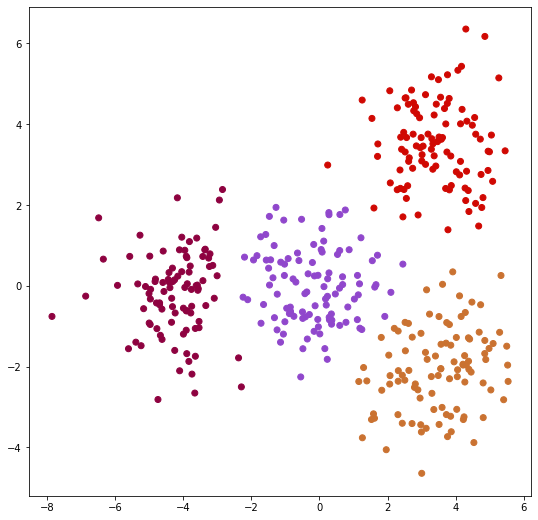

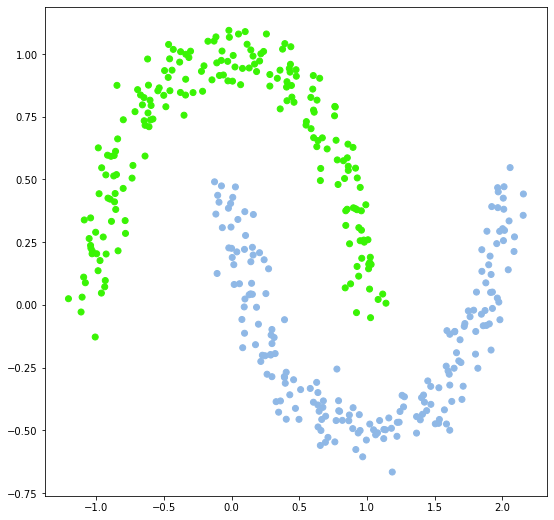

In [265]:
agg_clustering = AgglomertiveClustering(n_clusters=4)
labels = agg_clustering.fit_predict(X_1)
visualize_clasters(X_1, labels)

agg_clustering = AgglomertiveClustering(n_clusters=2, linkage = "single")
labels = agg_clustering.fit_predict(X_2)
visualize_clasters(X_2, labels)